# Calculating contributing geologic units to Mataquito River

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from matplotlib.patches import Polygon
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as mcolors
import rasterio
from rasterio.plot import show
from pyproj import Proj, transform

In [9]:
# import excel file
excel_path = "/Users/Glong1/Desktop/Andes/AndesTG/Mataquito/Geology/subwatershed_geologic_units_data.xlsx"
xls = pd.ExcelFile(excel_path)

# get sheet names
sheet_names = xls.sheet_names

In [3]:
# Define non-geologic units to exclude from calculations
non_geologic_units = ['Lag', 'G', 'arg'] # the non-geoligc units are water bodies and areas that dont overlap with the geologic map and watershed boundary

# Create dictionary for stats on each subwatershed
def create_summary_dataframe(xls, sheet_names, exclude_units=None):
    if exclude_units is None:
        exclude_units = []
    
    summaries = {}
    excluded_summaries = {}
    
    for sheet in sheet_names:
        df = xls.parse(sheet)
        # ensure the columns are available
        if 'GEO' in df.columns and 'area_km2' in df.columns:
            df = df.dropna(subset=['GEO', 'area_km2'])
            
            # separate excluded units from geologic units
            excluded_df = df[df['GEO'].isin(exclude_units)]
            geologic_df = df[~df['GEO'].isin(exclude_units)]
            
            # process excluded units (for reporting only)
            if not excluded_df.empty:
                excluded_grouped = excluded_df.groupby('GEO', as_index=False)['area_km2'].sum()
                excluded_grouped.insert(0, 'Subwatershed', sheet)
                excluded_summaries[sheet] = excluded_grouped
            
            # process geologic units
            if not geologic_df.empty:
                grouped = geologic_df.groupby('GEO', as_index=False)['area_km2'].sum()
                total_geologic_area = grouped['area_km2'].sum()
                grouped['percent'] = (grouped['area_km2'] / total_geologic_area) * 100
                # add subwatershed name as a column 
                grouped.insert(0, 'Subwatershed', sheet)
                summaries[sheet] = grouped
    
    # create summary dataframes
    summary_df = pd.concat(summaries.values(), ignore_index=True) if summaries else pd.DataFrame()
    excluded_df_combined = pd.concat(excluded_summaries.values(), ignore_index=True) if excluded_summaries else pd.DataFrame()
    
    return summary_df, summaries, excluded_df_combined, excluded_summaries

In [4]:
summary_df, summaries, excluded_df, excluded_summaries = create_summary_dataframe(xls, sheet_names, non_geologic_units)

# Print results for each subwatershed
for key in summaries:
    print(f"\n{'='*60}")
    print(f"GEOLOGIC UNIT SUMMARY — {key}")
    print(f"{'='*60}")
    
    # Show geologic units
    sorted_df = summaries[key][['GEO', 'area_km2', 'percent']].sort_values(by='area_km2', ascending=False)
    print("\nGEOLOGIC UNITS:")
    print(sorted_df.to_string(index=False, float_format='%.3f'))
    
    geologic_total = sorted_df['area_km2'].sum()
    print(f"\nTotal geologic area: {geologic_total:.3f} km²")
    
    # Show excluded units if present
    if key in excluded_summaries:
        excluded_sorted = excluded_summaries[key][['GEO', 'area_km2']].sort_values(by='area_km2', ascending=False)
        print(f"\nEXCLUDED UNITS (water bodies & unmapped areas):")
        print(excluded_sorted.to_string(index=False, float_format='%.2f'))
        
        excluded_total = excluded_sorted['area_km2'].sum()
        total_area = geologic_total + excluded_total
        excluded_percent = (excluded_total / total_area) * 100
        
        print(f"\nTotal excluded area: {excluded_total:.3f} km² ({excluded_percent:.2f}% of total)")
        print(f"Total subwatershed area: {total_area:.3f} km²")
    else:
        print(f"\nNo excluded units found in {key}")

# Show unique geologic units found
print(f"\n{'='*60}")
if not summary_df.empty:
    unique_geo_units = sorted(summary_df['GEO'].unique())
    print(f"\nUnique geologic units found: {len(unique_geo_units)}")
    print("Units:", ", ".join(unique_geo_units))


GEOLOGIC UNIT SUMMARY — CT-1_w_geo

GEOLOGIC UNITS:
 GEO  area_km2  percent
OM2c   635.204   46.019
PPl3   292.223   21.171
Pl3t   203.481   14.742
 Q3i    92.580    6.707
  Q1    82.445    5.973
  Mg    39.887    2.890
 DC4    34.499    2.499

Total geologic area: 1380.320 km²

EXCLUDED UNITS (water bodies & unmapped areas):
GEO  area_km2
  G      1.38

Total excluded area: 1.377 km² (0.10% of total)
Total subwatershed area: 1381.697 km²

GEOLOGIC UNIT SUMMARY — CT-10_w_geo

GEOLOGIC UNITS:
  GEO  area_km2  percent
 OM2c  2205.493   45.545
   Q1   770.786   15.917
 Pl3t   343.074    7.085
 PPl3   334.284    6.903
 Kia2   252.975    5.224
 Q3av   194.926    4.025
  Q3i   159.793    3.300
 Js1c   141.752    2.927
   Mg   138.264    2.855
 Js1m    75.483    1.559
   Qf    75.041    1.550
Kia1c    37.569    0.776
  DC4    34.499    0.712
 Kiag    27.608    0.570
 JK1m    19.936    0.412
 Mimg    19.338    0.399
 Ki2c    11.592    0.239

Total geologic area: 4842.415 km²

EXCLUDED UNITS (

In [5]:
summary_df.to_excel('geologic_area-percents.xlsx', index=False)

In [10]:
# Excel file of data
import pandas as pd

# Set the output Excel path
output_path = "combined_subwatershed_summary.xlsx"

with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    worksheet = writer.book.add_worksheet("Geologic Summary")
    writer.sheets["Geologic Summary"] = worksheet

    row = 0  # Start at top of the sheet

    for key in summaries:
        geo_df = summaries[key][['GEO', 'area_km2', 'percent']].sort_values(by='area_km2', ascending=False)
        
        # Write subwatershed title
        worksheet.write(row, 0, f"Geologic Unit Summary — {key}")
        row += 2

        # Write geologic units table
        geo_df.to_excel(writer, sheet_name="Geologic Summary", index=False, startrow=row, startcol=0, header=True)
        row += len(geo_df) + 1

        # Write geologic total
        geologic_total = geo_df['area_km2'].sum()
        worksheet.write(row, 0, 'Total geologic area:')
        worksheet.write(row, 1, geologic_total)
        row += 2

        # If excluded units exist, write them
        if key in excluded_summaries:
            excluded_df = excluded_summaries[key][['GEO', 'area_km2']].sort_values(by='area_km2', ascending=False)

            worksheet.write(row, 0, 'Excluded Units (water bodies & unmapped areas):')
            row += 1

            excluded_df.to_excel(writer, sheet_name="Geologic Summary", index=False, startrow=row, startcol=0, header=True)
            row += len(excluded_df) + 1

            excluded_total = excluded_df['area_km2'].sum()
            total_area = geologic_total + excluded_total
            excluded_percent = (excluded_total / total_area) * 100

            worksheet.write(row, 0, 'Total excluded area:')
            worksheet.write(row, 1, excluded_total)
            row += 1
            worksheet.write(row, 0, 'Excluded area percent:')
            worksheet.write(row, 1, excluded_percent)
            row += 1
            worksheet.write(row, 0, 'Total subwatershed area:')
            worksheet.write(row, 1, total_area)
            row += 2
        else:
            worksheet.write(row, 0, f"No excluded units found in {key}")
            row += 2

        # Add a blank row between blocks
        row += 2


NameError: name 'summaries' is not defined

## Latex
Making the tables for the geologic data

In [7]:
summary_df.to_excel('mata_geologic_units.xlsx', index=False, sheet_name='Combined_Summary')
def generate_latex_tables(summaries, excluded_summaries, summary_df):
    """
    Generate LaTeX tables from geologic unit summary data.
    
    Parameters:
    - summaries: dict of DataFrames with geologic unit data for each subwatershed
    - excluded_summaries: dict of DataFrames with excluded unit data
    - summary_df: combined DataFrame with all unique geologic units
    
    Returns:
    - string: Complete LaTeX document content
    """
    
    latex_content = []
    
    # Document header
    latex_content.extend([
        "\\documentclass[11pt]{article}",
        "\\usepackage[margin=1in]{geometry}",
        "\\usepackage{booktabs}",
        "\\usepackage{array}",
        "\\usepackage{longtable}",
        "\\usepackage{multirow}",
        "\\usepackage{siunitx}",
        "\\usepackage{xcolor}",
        "",
        "% Define column types for better formatting",
        "\\newcolumntype{L}[1]{>{\\raggedright\\arraybackslash}p{#1}}",
        "\\newcolumntype{C}[1]{>{\\centering\\arraybackslash}p{#1}}",
        "\\newcolumntype{R}[1]{>{\\raggedleft\\arraybackslash}p{#1}}",
        "",
        "\\title{Geologic Unit Summary Tables}",
        "\\author{Generated from Python Analysis}",
        "\\date{\\today}",
        "",
        "\\begin{document}",
        "",
        "\\maketitle",
        ""
    ])
    
    # Generate tables for each subwatershed
    for i, key in enumerate(summaries.keys()):
        # Clean subwatershed name for LaTeX (replace underscores, etc.)
        clean_key = key.replace('_', '\\_').replace('&', '\\&')
        
        latex_content.extend([
            f"\\section{{Subwatershed: {clean_key}}}",
            ""
        ])
        
        # Geologic units table
        sorted_df = summaries[key][['GEO', 'area_km2', 'percent']].sort_values(by='area_km2', ascending=False)
        
        latex_content.extend([
            "\\subsection{Geologic Units}",
            "\\begin{table}[h!]",
            "\\centering",
            f"\\caption{{Geologic Units Distribution - {clean_key}}}",
            "\\begin{tabular}{@{}L{3cm}S[table-format=3.2]S[table-format=2.1]@{}}",
            "\\toprule",
            "\\textbf{Geologic Unit} & \\textbf{Area (km²)} & \\textbf{Percent (\\%)} \\\\",
            "\\midrule"
        ])
        
        # Add data rows
        for _, row in sorted_df.iterrows():
            geo_unit = str(row['GEO']).replace('_', '\\_').replace('&', '\\&')
            latex_content.append(f"{geo_unit} & {row['area_km2']:.2f} & {row['percent']:.1f} \\\\")
        
        # Add total row
        total_area = sorted_df['area_km2'].sum()
        latex_content.extend([
            "\\midrule",
            f"\\textbf{{Total}} & \\textbf{{{total_area:.2f}}} & \\textbf{{100.0}} \\\\",
            "\\bottomrule",
            "\\end{tabular}",
            "\\end{table}",
            ""
        ])
        
        # Excluded units table (if present)
        if key in excluded_summaries and not excluded_summaries[key].empty:
            excluded_sorted = excluded_summaries[key][['GEO', 'area_km2']].sort_values(by='area_km2', ascending=False)
            
            latex_content.extend([
                "\\subsection{Excluded Units}",
                "\\begin{table}[h!]",
                "\\centering",
                f"\\caption{{Excluded Units (Water Bodies \\& Unmapped Areas) - {clean_key}}}",
                "\\begin{tabular}{@{}L{4cm}S[table-format=2.2]@{}}",
                "\\toprule",
                "\\textbf{Excluded Unit Type} & \\textbf{Area (km²)} \\\\",
                "\\midrule"
            ])
            
            # Add excluded unit rows
            for _, row in excluded_sorted.iterrows():
                geo_unit = str(row['GEO']).replace('_', '\\_').replace('&', '\\&')
                latex_content.append(f"{geo_unit} & {row['area_km2']:.2f} \\\\")
            
            # Add excluded total
            excluded_total = excluded_sorted['area_km2'].sum()
            total_subwatershed_area = total_area + excluded_total
            excluded_percent = (excluded_total / total_subwatershed_area) * 100
            
            latex_content.extend([
                "\\midrule",
                f"\\textbf{{Total Excluded}} & \\textbf{{{excluded_total:.2f}}} \\\\",
                "\\bottomrule",
                "\\end{tabular}",
                "\\end{table}",
                ""
            ])
            
            # Summary statistics
            latex_content.extend([
                "\\textbf{Summary Statistics:}",
                "\\begin{itemize}",
                f"\\item Total geologic area: {total_area:.2f} km²",
                f"\\item Total excluded area: {excluded_total:.2f} km² ({excluded_percent:.1f}\\% of total)",
                f"\\item Total subwatershed area: {total_subwatershed_area:.2f} km²",
                "\\end{itemize}",
                ""
            ])
        else:
            latex_content.extend([
                f"\\textbf{{Note:}} No excluded units found in {clean_key}",
                f"\\textbf{{Total subwatershed area:}} {total_area:.2f} km²",
                ""
            ])
        
        # Add page break between subwatersheds (except for the last one)
        if i < len(summaries) - 1:
            latex_content.append("\\newpage")
            latex_content.append("")
    
    # Summary of unique geologic units
    if not summary_df.empty:
        unique_geo_units = sorted(summary_df['GEO'].unique())
        num_units = len(unique_geo_units)
        
        latex_content.extend([
            "\\section{Summary of All Unique Geologic Units}",
            "",
            f"\\textbf{{Total unique geologic units found:}} {num_units}",
            ""
        ])
        
        # Create a formatted list of units (handle long lists by breaking into columns)
        if num_units <= 20:
            # Short list - simple table format
            latex_content.extend([
                "\\begin{table}[h!]",
                "\\centering",
                "\\caption{Complete List of Unique Geologic Units}",
                "\\begin{tabular}{@{}L{2cm}L{2cm}L{2cm}L{2cm}@{}}",
                "\\toprule",
                "\\multicolumn{4}{c}{\\textbf{Geologic Unit Codes}} \\\\",
                "\\midrule"
            ])
            
            # Add units in rows of 4
            for i in range(0, len(unique_geo_units), 4):
                row_units = unique_geo_units[i:i+4]
                # Clean unit names for LaTeX
                clean_units = [unit.replace('_', '\\_').replace('&', '\\&') for unit in row_units]
                # Pad with empty cells if needed
                while len(clean_units) < 4:
                    clean_units.append("")
                latex_content.append(" & ".join(clean_units) + " \\\\")
            
            latex_content.extend([
                "\\bottomrule",
                "\\end{tabular}",
                "\\end{table}"
            ])
        else:
            # Long list - paragraph format
            clean_units = [unit.replace('_', '\\_').replace('&', '\\&') for unit in unique_geo_units]
            units_text = ", ".join(clean_units)
            latex_content.extend([
                "\\textbf{Geologic Units:}",
                "",
                units_text
            ])
    
    # Document footer
    latex_content.extend([
        "",
        "\\end{document}"
    ])
    
    return "\n".join(latex_content)


def save_latex_file(latex_content, filename="geologic_summary.tex"):
    """
    Save LaTeX content to a file.
    
    Parameters:
    - latex_content: string with LaTeX code
    - filename: output filename
    """
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(latex_content)
    print(f"LaTeX file saved as: {filename}")


def create_summary_table_only(summaries, excluded_summaries):
    """
    Create a simplified summary table with all subwatersheds in one table.
    
    Parameters:
    - summaries: dict of DataFrames with geologic unit data
    - excluded_summaries: dict of DataFrames with excluded unit data
    
    Returns:
    - string: LaTeX table code for summary
    """
    
    latex_content = []
    
    latex_content.extend([
        "\\begin{longtable}{@{}L{3cm}S[table-format=3.2]S[table-format=2.2]S[table-format=3.2]@{}}",
        "\\caption{Summary of All Subwatersheds} \\\\",
        "\\toprule",
        "\\textbf{Subwatershed} & \\textbf{Geologic Area} & \\textbf{Excluded Area} & \\textbf{Total Area} \\\\",
        "& \\textbf{(km²)} & \\textbf{(km²)} & \\textbf{(km²)} \\\\",
        "\\midrule",
        "\\endfirsthead",
        "",
        "\\multicolumn{4}{c}{{\\tablename\\ \\thetable{} -- continued from previous page}} \\\\",
        "\\toprule",
        "\\textbf{Subwatershed} & \\textbf{Geologic Area} & \\textbf{Excluded Area} & \\textbf{Total Area} \\\\",
        "& \\textbf{(km²)} & \\textbf{(km²)} & \\textbf{(km²)} \\\\",
        "\\midrule",
        "\\endhead",
        "",
        "\\bottomrule",
        "\\multicolumn{4}{r}{{Continued on next page}} \\\\",
        "\\endfoot",
        "",
        "\\bottomrule",
        "\\endlastfoot"
    ])
    
    total_geologic = 0
    total_excluded = 0
    
    for key in summaries.keys():
        clean_key = key.replace('_', '\\_').replace('&', '\\&')
        geologic_area = summaries[key]['area_km2'].sum()
        
        if key in excluded_summaries and not excluded_summaries[key].empty:
            excluded_area = excluded_summaries[key]['area_km2'].sum()
        else:
            excluded_area = 0
        
        total_area = geologic_area + excluded_area
        
        latex_content.append(f"{clean_key} & {geologic_area:.2f} & {excluded_area:.2f} & {total_area:.2f} \\\\")
        
        total_geologic += geologic_area
        total_excluded += excluded_area
    
    # Add totals row
    grand_total = total_geologic + total_excluded
    latex_content.extend([
        "\\midrule",
        f"\\textbf{{TOTAL}} & \\textbf{{{total_geologic:.2f}}} & \\textbf{{{total_excluded:.2f}}} & \\textbf{{{grand_total:.2f}}} \\\\",
        "\\end{longtable}"
    ])
    
    return "\n".join(latex_content)


# Main execution code
if __name__ == "__main__":
    # Assuming you have your data structures ready:
    # summaries, excluded_summaries, summary_df from your existing code
    
    # Generate complete LaTeX document
    latex_document = generate_latex_tables(summaries, excluded_summaries, summary_df)
    
    # Save to file
    save_latex_file(latex_document, "geologic_summary_complete.tex")
    
    # Generate summary table only
    summary_table = create_summary_table_only(summaries, excluded_summaries)
    
    # Save summary table separately
    with open("summary_table_only.tex", 'w', encoding='utf-8') as f:
        f.write(summary_table)
    
    print("LaTeX files generated successfully!")
    print("- Complete document: geologic_summary_complete.tex")
    print("- Summary table only: summary_table_only.tex")
    
    # Optional: Display the first few lines of the generated LaTeX
    print("\nFirst 20 lines of generated LaTeX:")
    print("=" * 50)
    lines = latex_document.split('\n')
    for line in lines[:20]:
        print(line)

LaTeX file saved as: geologic_summary_complete.tex
LaTeX files generated successfully!
- Complete document: geologic_summary_complete.tex
- Summary table only: summary_table_only.tex

First 20 lines of generated LaTeX:
\documentclass[11pt]{article}
\usepackage[margin=1in]{geometry}
\usepackage{booktabs}
\usepackage{array}
\usepackage{longtable}
\usepackage{multirow}
\usepackage{siunitx}
\usepackage{xcolor}

% Define column types for better formatting
\newcolumntype{L}[1]{>{\raggedright\arraybackslash}p{#1}}
\newcolumntype{C}[1]{>{\centering\arraybackslash}p{#1}}
\newcolumntype{R}[1]{>{\raggedleft\arraybackslash}p{#1}}

\title{Geologic Unit Summary Tables}
\author{Generated from Python Analysis}
\date{\today}

\begin{document}



# pie charts

In [8]:
# Create pie charts
def create_pie_charts(summaries):
    """Create pie charts for each subwatershed"""
    print(f"\nCreating pie charts for {len(summaries)} subwatersheds...")
    
    # Get all unique GEO units across all subwatersheds
    all_geo_units = set()
    for data in summaries.values():
        all_geo_units.update(data['GEO'].values)
    all_geo_units = sorted(list(all_geo_units))
    
    # Create consistent color mapping for each GEO unit using multiple color palettes
    # Combine multiple color palettes to get more distinct colors
    colors1 = plt.cm.Set3(np.linspace(0, 1, 12))
    colors2 = plt.cm.Pastel1(np.linspace(0, 1, 9))
    colors3 = plt.cm.Dark2(np.linspace(0, 1, 8))
    colors4 = plt.cm.Accent(np.linspace(0, 1, 8))
    
    all_colors = np.concatenate([colors1, colors2, colors3, colors4])
    
    geo_color_map = {geo: all_colors[i % len(all_colors)] for i, geo in enumerate(all_geo_units)}
    
    # Calculate subplot layout
    n_subs = len(summaries)
    n_cols = 2 if n_subs > 1 else 1
    n_rows = (n_subs + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    # Handle single subplot case
    if n_subs == 1:
        axes = [axes]
    elif n_rows == 1 and n_cols > 1:
        axes = list(axes)
    elif n_rows > 1:
        axes = axes.flatten()
    
    # Create each pie chart
    for i, (subwatershed, data) in enumerate(summaries.items()):
        ax = axes[i]
        
        # Prepare labels, sizes, and colors for this subwatershed
        labels = []
        sizes = data['percent'].values
        chart_colors = []
        
        for _, row in data.iterrows():
            labels.append(f"{row['GEO']}")
            chart_colors.append(geo_color_map[row['GEO']])
        
        # Create pie chart
        ax.pie(sizes, labels=labels, colors=chart_colors, 
               startangle=90, textprops={'fontsize': 9})
        
        # Title
        ax.set_title(f"{subwatershed}\nTotal: {data['area_km2'].sum():.1f} km²", 
                    fontsize=12, fontweight='bold', pad=20)
        ax.axis('equal')
    
    # Hide unused subplots
    for i in range(len(summaries), len(axes)):
        axes[i].axis('off')
    
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()



Creating pie charts for 11 subwatersheds...


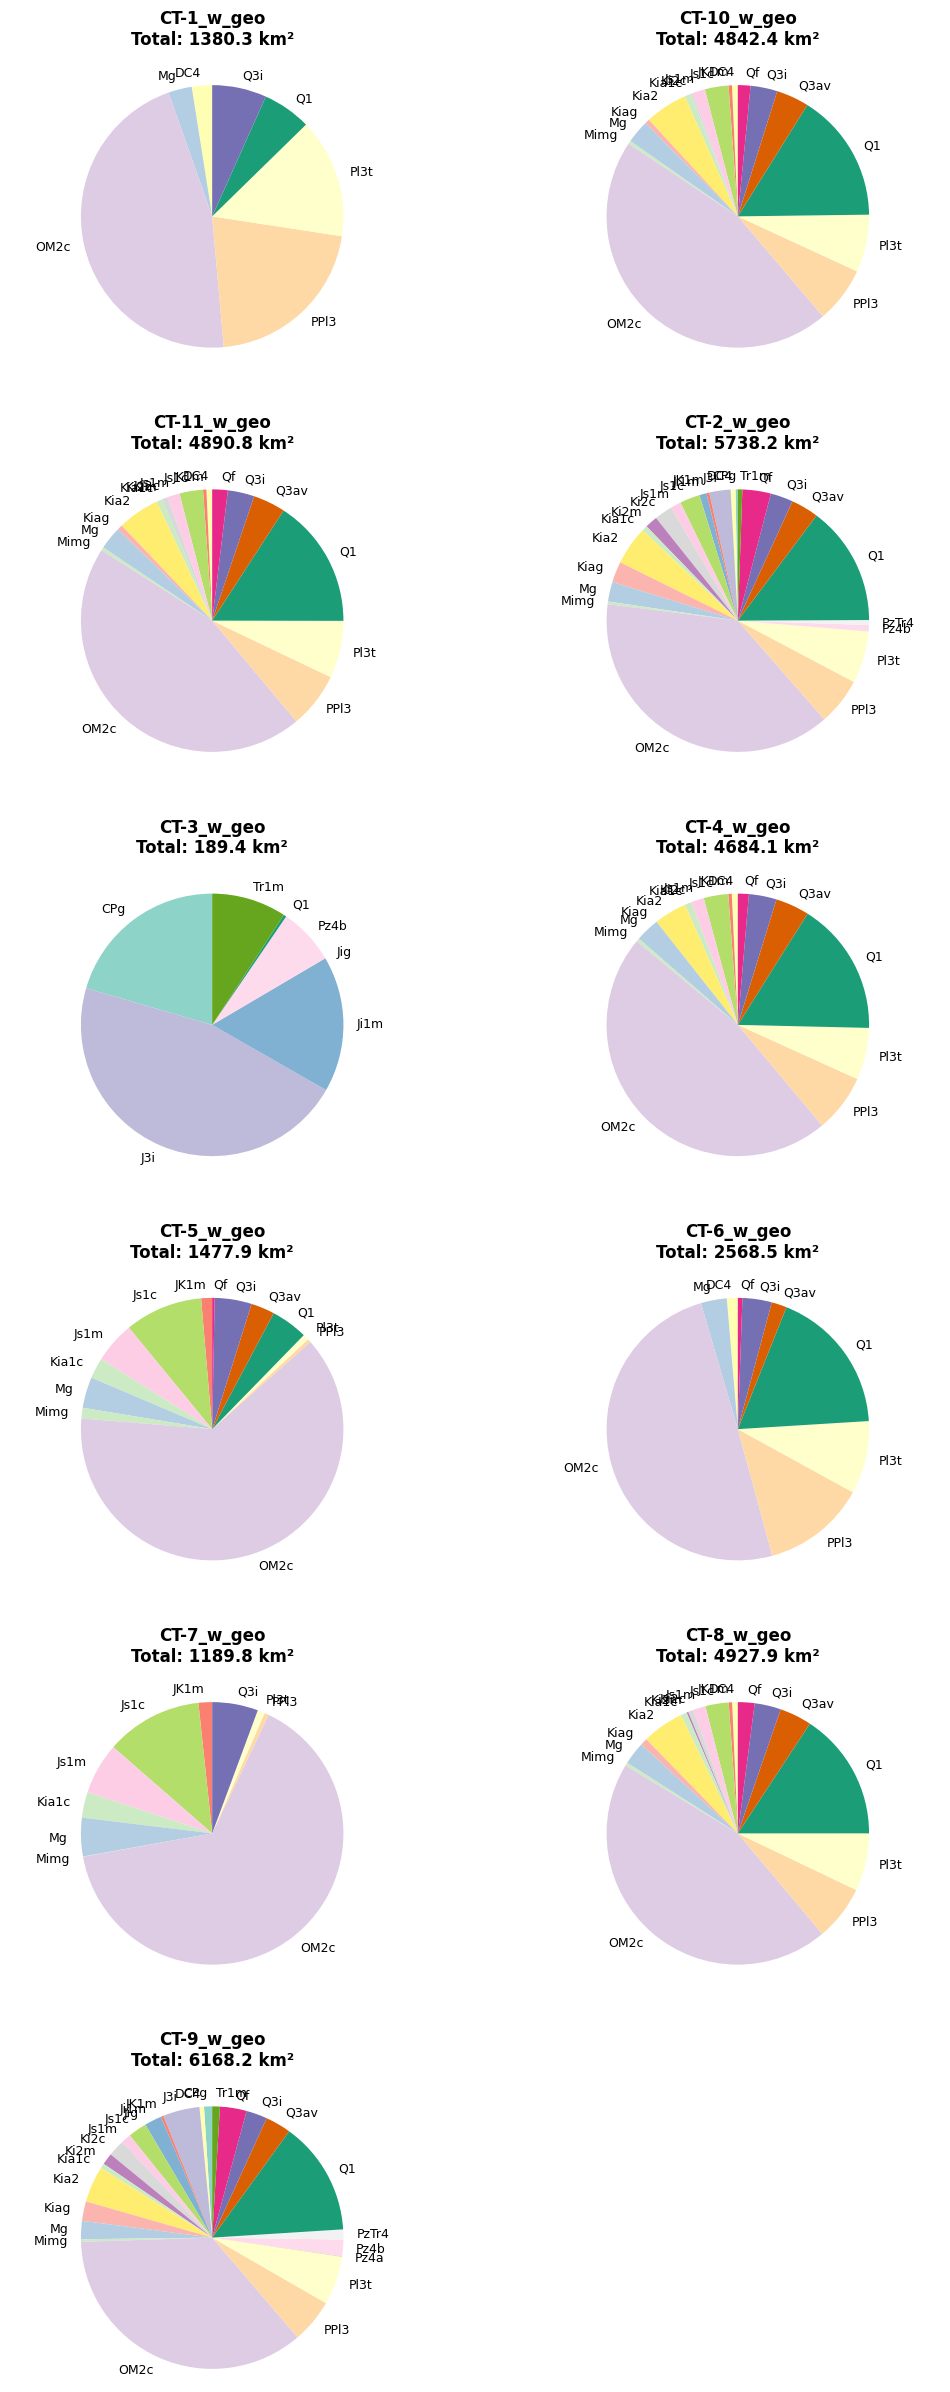

In [9]:
# Run the display and charts
create_pie_charts(summaries)

# Geologic map
### Plotting the whole geologic map with units

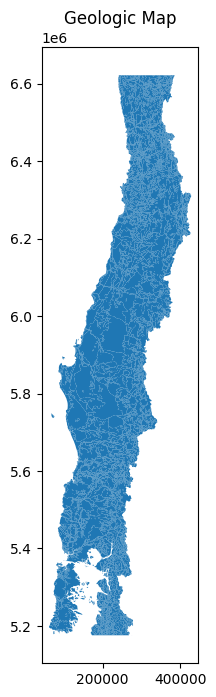

In [11]:
# Load and plot the shapefile for the whole map
gdf = gpd.read_file('/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/geo_centro_u19.shp')

# Quick plot
gdf.plot(figsize=(10, 8))
plt.title('Geologic Map')
plt.show()

In [12]:
gdf = gpd.read_file('/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/geo_centro_u19.shp')
print(gdf.columns)  # See all column names
print(gdf.head())   # See first few rows of data

Index(['AREA', 'PERIMETER', 'GEOLOGIA_', 'GEOLOGIA_I', 'AREATNT', 'PERIMETERT',
       'GEOLCEN_', 'GEOLCEN_ID', 'ITEM002', 'ITEM001', 'GEO_', 'GEO_ID', 'GEO',
       'geometry'],
      dtype='object')
           AREA  PERIMETER  GEOLOGIA_  GEOLOGIA_I       AREATNT  PERIMETERT  \
0  4.368528e+09   717803.1          2           2  4.368528e+09    711696.6   
1  5.214349e+09   923144.4          3           3  5.214349e+09    925742.1   
2  1.482286e+08   369994.3          4           4  1.482286e+08    370145.8   
3  2.979063e+09   380001.0          5           5  2.979063e+09    380973.6   
4  1.058153e+09   254435.2          6           6  1.058153e+09    255650.0   

   GEOLCEN_  GEOLCEN_ID  ITEM002  ITEM001  GEO_  GEO_ID   GEO  \
0      2078        2082      0.0      0.0  2080    2079  Pl3t   
1      1838        1851      0.0      0.0  1840    1839    Q1   
2      1974        1973      0.0      0.0  1975    1974   Rio   
3      1928        1933      0.0      0.0  1930    1929   CPg  

In [13]:
geologic_colors = {
    # SEDIMENTARY SEQUENCES (Column 1)
    # Quaternary
    'Qan': '#ffffc5',        # Holocene deposits
    'Q1': '#ffff6e',        # Pleistocene-Holocene alluvial/colluvial deposits
    'Qf': '#ffffe2',        # Pleistocene-Holocene fluvial deposits
    'Qm': '#f5ff6e',        # Pleistocene-Holocene coastal deposits
    'Qa': '#f5ffa8',        # Pleistocene-Holocene alluvial deposits
    'Q1g': '#f5ff00',       # Pleistocene-Holocene morainic/fluvioglacial
    'Q1g1': '#ffffc5',       # Pleistocene-Holocene morainic/fluvioglacial
    'Q1g2': '#ffff51',
    'Q1g3': '#faff51',
    'Q1g4': '#f0ff6e',
    'Qe': '#ffff8b',        # Pleistocene-Holocene eolian deposits
    
    # Neogene
    'Pl1m': '#ffff34',      # Pleistocene marine sequences
    'PPl1r': '#fac56e',     # Pliocene-Pleistocene mass removal deposits
    'PPl1c': '#ffff17',     # Pliocene-Pleistocene conglomerates/sandstones
    'PPl1l': '#faff51',     # Pliocene-Pleistocene lacustrine sequences
    'MQs': '#d8feff',       # Miocene-Quaternary evaporites
    'MP1m': '#ffe2e2',      # Upper Miocene-Pliocene marine sequences
    'MP1c': '#fac58b',      # Upper Miocene-Pliocene clastic sequences
    'MP1l': '#faa88b',      # Upper Miocene-Pliocene lacustrine sequences
    'M1c': '#fae28b',       # Lower-Middle Miocene alluvial fan sequences
    'M1m': '#fa8bc5',       # Miocene marine sequences
    'OM1m': '#ffc517',      # Oligocene-Miocene marine sequences
    'OM1c': '#ffa86e',      # Oligocene-Miocene continental sequences
    'EM1m': '#e2c58b',      # Eocene-Miocene marine sequences
    
    # Paleogene
    'EO1c': '#e28b34',      # Eocene-Oligocene continental sequences
    'E1c': '#faa86e',       # Eocene continental sequences
    'E1m': '#fae200',       # Eocene marine sequences
    'PE1c': '#b78b51',      # Paleocene-Lower Eocene continental sequences
    'PE1': '#c1955b',       # Paleocene-Eocene marine/transitional sequences
    'Pa1m': '#ffff51',      # Paleocene marine sequences
    
    # Cretaceous-Tertiary
    'KT1c': '#e2c56e',      # Upper Cretaceous-Lower Tertiary continental
    
    # Cretaceous
    'Ks1m': '#17ff6e',      # Upper Cretaceous marine sequences
    'Ks1mp': '#cee251',     # Campanian-Maastrichtian marine/paralic
    'Ks1c': '#b7ff8b',      # Upper Cretaceous continental sequences
    'Kia1c': '#17ffa8',     # Upper Lower Cretaceous continental sequences
    'Ki1m': '#6ec517',      # Lower Cretaceous marine sequences
    
    # Jurassic-Cretaceous
    'JK1m': '#85a800',      # Upper Jurassic-Lower Cretaceous marine
    'JK1c': '#8bffc5',      # Upper Jurassic-Lower Cretaceous continental
    'JK1': '#17ffc5',       # Upper Jurassic-Lower Cretaceous transitional
    
    # Jurassic
    'J1m': '#ebffff',       # Jurassic-Neocomian marine sequences
    'Js1c': '#b7e2ff',      # Upper Jurassic continental sequences
    'Js1m': '#17a8ff',      # Middle-Upper Jurassic marine sequences
    'Ji1m': '#ceffff',      # Lower-Middle Jurassic marine sequences
    
    # Triassic-Jurassic
    'TrJ1m': '#a5f5fe',     # Triassic-Lower Jurassic marine sequences
    'TrJ1c': '#6eedc3',     # Triassic-Lower Jurassic continental sequences
    
    # Triassic
    'Tr1c': '#cee2c5',      # Upper Triassic continental sequences
    'Tr1m': '#cee2ff',      # Upper Triassic marine sequences
    
    # Permian
    'P1m': '#aa826e',       # Permian turbidites
    
    # Carboniferous-Permian
    'CP1': '#ffdfff',       # Upper Carboniferous-Permian sequences
    
    # Devonian-Triassic
    'DTr1c': '#e1e173',     # Devonian-Triassic continental sequences
    
    # Devonian-Carboniferous
    'DC1': '#b76e00',       # Devonian-Carboniferous marine sequences
    
    # Ordovician-Silurian
    'OS1m': '#9b9b9b',      # Ordovician-Silurian marine sequences
    
    # Cambrian-Ordovician
    'CaO1m': '#3939ff',     # Cambrian-Ordovician marine sequences
    
    # Cambrian-Devonian
    'CaD1': '#efefff',      # Middle Cambrian-Devonian sequences
    
    # Cambrian
    'Ca1': '#5858ff',       # Cambrian sequences
    
    # VOLCANOSEDIMENTARY SEQUENCES (Column 2)
    # Neogene
    'MP2': '#f5a8a8',       # Upper Miocene-Pliocene volcanosedimentary
    'M2c': '#ffa817',       # Lower-Middle Miocene volcanosedimentary
    'OM2m': '#fac534',      # Oligocene-Miocene marine volcanosedimentary
    'OM2c': '#f0ffa8',      # Oligocene-Miocene volcanosedimentary
    
    # Paleogene
    'EO2c': '#c56e00',      # Eocene-Oligocene volcanosedimentary
    'E2c': '#a86e6e',       # Eocene volcanosedimentary
    
    # Cretaceous-Tertiary
    'KT2': '#a8ff8b',       # Upper Cretaceous-Lower Tertiary volcanosedimentary
    'KE2': '#a8ff64',       # Cretaceous-Eocene volcanosedimentary
    
    # Cretaceous
    'Ks2c': '#6eff6e',      # Upper Cretaceous continental volcanosedimentary
    'Ks2m': '#c1ff95',      # Upper Cretaceous marine volcanoclastic
    'Kia2': '#cee26e',      # Upper Lower-Lower Upper Cretaceous sequences
    'Ki2c': '#81ff81',      # Lower-Upper Cretaceous continental sequences
    'Ki2m': '#8ba86e',      # Lower Cretaceous marine volcanic/sedimentary
    
    # Jurassic
    'J2m': '#c5ffff',       # Jurassic marine volcanic/sedimentary
    'Js2c': '#0ecdff',      # Middle-Upper Jurassic continental sequences
    
    # Triassic-Cretaceous
    'TrK2': '#8b51e2',      # Triassic-Cretaceous turbidites/basalts
    
    # Triassic
    'Tr2c': '#c5e2c5',      # Middle-Upper Triassic continental sequences
    
    # Carboniferous-Permian
    'CP2m': '#b7e2a8',      # Carboniferous-Permian marine volcanosedimentary
    'CP2': '#b7e2c5',       # Carboniferous-Permian continental sequences
    
    # VOLCANIC SEQUENCES (Column 3)
    # Quaternary
    'Q3i': '#e26eff',       # Quaternary stratovolcanoes/volcanic complexes
    'Q3t': 'fad8ec',       # Quaternary pyroclastic flow deposits
    'Q3av': '#fae2c5',      # Quaternary volcanic avalanche deposits
    
    # Neogene
    'Pl3': '#e9e9ff',       # Pleistocene lava sequences/volcanic centers
    'Pl3t': '#fae2e2',      # Pleistocene pyroclastic deposits
    'PPl3': '#ffe9e9',      # Pliocene-Pleistocene volcanic sequences
    'P3t': '#ffc513',       # Pliocene pyroclastic deposits
    'P3i': '#ffc5ff',       # Pliocene volcanic centers
    'MP3': '#ffc58b',       # Miocene-Pliocene plateau basalts
    'Ms3t': '#ffc534',      # Upper Miocene ignimbrites
    'Ms3i': '#fa8b6e',      # Upper Miocene volcanic centers/sequences
    'M3o': '#e25100',       # Miocene ophiolites
    'M3av': '#ce6eff',      # Lower-Middle Miocene volcanic avalanche
    'M3b': '#f5c5a8',       # Miocene basaltic lavas
    'M3t': '#ffa800',       # Lower-Middle Miocene pyroclastic sequences
    'M3i': '#ffe26e',       # Lower-Middle Miocene volcanic complexes
    'OM3t': '#ff8bff',      # Oligocene-Miocene pyroclastic sequences
    'OM3': '#ffa8ff',       # Oligocene-Miocene volcanic sequences/centers
    'OM3b': '#ffe2c5',      # Oligocene-Miocene basic volcanic sequences
    
    # Paleogene
    'E3b': '#c56e17',       # Eocene plateau basalts
    'E3': '#8b5117',        # Eocene volcanic sequences/centers
    'PE3a': '#d85134',      # Paleocene-Lower Eocene acidic volcanic sequences
    'PE3i': '#f56e6e',      # Paleocene-Lower Eocene intermediate volcanic
    
    # Cretaceous
    'Ks3a': '#b7ff51',      # Upper Cretaceous acidic volcanic sequences
    'Ks3i': '#b7ff6e',      # Upper Cretaceous intermediate volcanic sequences
    'Kia3': '#6effa8',      # Upper Lower Cretaceous volcanic sequences
    
    # Jurassic-Tertiary
    'JT3': '#00abab',       # Jurassic-Tertiary basalts/andesites/rhyolites
    
    # Jurassic-Cretaceous
    'JK3o': '#8bffe2',      # Jurassic-Cretaceous ophiolitic complexes
    'JK3': '#17e2e2',       # Upper Jurassic-Lower Cretaceous volcanic
    
    # Jurassic
    'J3a': '#b7cde2',       # Jurassic acidic volcanic sequences
    'J3i': '#c5e2ff',       # Jurassic intermediate volcanic sequences
    
    # Triassic-Jurassic
    'TrJ3': '#cdf5fe',      # Triassic-Lower Jurassic volcanic sequences
    
    # Permian-Triassic
    'PTr3': '#a8a8a8',      # Permian-Triassic volcanic sequences
    
    # Carboniferous-Permian
    'CP3': '#a8e26e',       # Carboniferous-Permian volcanic sequences
    
    # Ordovician-Silurian
    'OS3': '#6e6e8b',       # Ordovician-Silurian volcanic sequences
    
    # INTRUSIVE ROCKS (Column g)
    # Neogene
    'Pg': '#ff3434',        # Pliocene granodiorites/tonalites/monzogranites
    'Msh': '#faa800',       # Upper Miocene porphyries (giant copper porphyry)
    'Msg': '#ff3451',       # Upper Miocene granodiorites
    'Mh': '#d8a800',        # Miocene porphyries
    'Mg': '#ff8ba8',        # Miocene granodiorites/diorites/tonalites
    'Mimg': '#fa51a8',      # Lower-Middle Miocene granodiorites/monzogranites
    
    # Paleogene
    'Og': '#fa8be2',        # Oligocene granodiorites/monzogranites/tonalites
    'EOp': '#f534c5',       # Eocene-Oligocene porphyries (giant copper porphyry)
    'Eg': '#ff51a8',        # Eocene granodiorites/tonalites
    'PEg': '#fa8bff',       # Paleocene-Eocene monzodiorites/granodiorites
    'Pag': '#ff3400',       # Paleocene monzodiorites/granodiorites
    
    # Cretaceous-Tertiary
    'KTg': '#ff6e34',       # Upper Cretaceous-Lower Tertiary granodiorites
    'KTg(a)': '#fa6ec5',
    
    # Cretaceous
    'Ksg': '#ff34e2',       # Upper Cretaceous monzodiorites/granodiorites
    'Ksh': '#ff8be2',       # Upper Cretaceous porphyries
    'Kiag': '#fa34c5',      # Upper Lower-Lower Upper Cretaceous diorites
    'Kibg': '#ff6ec5',      # Lower Lower Cretaceous monzodiorites/diorites
    'Kig': '#ff34a8',       # Lower Cretaceous granites/granodiorites
    
    # Jurassic-Cretaceous
    'JKg': '#ffa8e2',       # Jurassic-Cretaceous granodiorites/diorites
    
    # Jurassic
    'Jsg': '#faa8a8',       # Middle-Upper Jurassic monzodiorites/diorites
    'Jig': '#fa8b8b',       # Lower Jurassic diorites/gabros
    
    # Triassic-Jurassic
    'TrJg': '#f551e2',      # Triassic-Jurassic granodiorites/monzogranites
    
    # Triassic
    'Trg': '#eb34c5',       # Triassic leucocratic granites/monzogranites
    
    # Permian-Triassic
    'PTrg': '#ff6d6d',      # Permian-Triassic hololeucocratic granites
    
    # Carboniferous-Permian
    'CPg': '#ffe2ff',       # Carboniferous-Permian granites/granodiorites
    
    # Ordovician-Silurian
    'OSg': 'f58be2',       # Ordovician-Silurian leucocratic granites
    
    # METAMORPHIC ROCKS (Column 4)
    # Neogene
    'OM4': '#ffe2ff',       # Oligocene-Miocene metasediments/metabasites
    
    # Jurassic-Tertiary
    'JT4a': '#ceceb1',      # Jurassic-Tertiary low P/T gradient schists
    'JT4b': '#d8d8bb',      # Jurassic-Tertiary high P/T gradient schists
    
    # Jurassic
    'Js4': '#e2e2c5',       # Upper Jurassic high P/T gradient schists
    'Jsg4': '#17ff00',      # Upper Jurassic orthogneisses
    
    # Triassic
    'Tr4a': '#c58bc5',      # Triassic low grade metaturbidites
    'Tr4b': '#e28bc5',      # Triassic micaceous schists/phyllites
    
    # Permian-Cretaceous
    'PK4': '#f0e1af',       # Permian-Cretaceous gneisses/metabasites
    
    # Permian-Triassic
    'PTr4': '#f0e2c5',      # Permian-Triassic low grade metaturbidites
    'PzTr4': '#f0e2c5',     # Paleozoic-Triassic metapelites/metacherts
    'PzTr4(a)': '#f7f7f7',
    'PzTr4(b)': '#fcfcfc',
    
    # Devonian-Carboniferous
    'DC4': '#f0e2e2',       # Devonian-Carboniferous metasandstones/phyllites
    
    # Silurian-Carboniferous
    'Pz4a': '#f2f2f2',      # Silurian-Carboniferous high P/T schists (Western)
    'Pz4b': '#eaeaea',      # Silurian-Carboniferous low P/T schists (Eastern)
    
    # Precambrian-Permian
    'pCP4': '#ceceaa',      # Precambrian-Permian micaceous schists/metabasites
    
    # Precambrian-Ordovician
    'pCO4': '#d6d6d6',      # Precambrian-Ordovician micaceous schists/gneisses
    
    # SPECIAL UNITS
    'Rio': '#66CCFF',       # Rivers/water bodies
    'Lag': '#66CCFF',       # Lakes/water bodies
    'G': '#66CCFF',         # Water bodies
    'arg': '#000000',       # Area outside geologic map
}

Lines loaded successfully
Faults loaded successfully
Fault symbols loaded successfully
Hillshade loaded successfully
North arrow PNG loaded successfully
Plot saved to: /Users/Glong1/Desktop/Andes/Mataquito_Manuscript/mataquito_geology_1-1000000.png
PDF version saved to: /Users/Glong1/Desktop/Andes/Mataquito_Manuscript/mataquito_geology_1-1000000.pdf


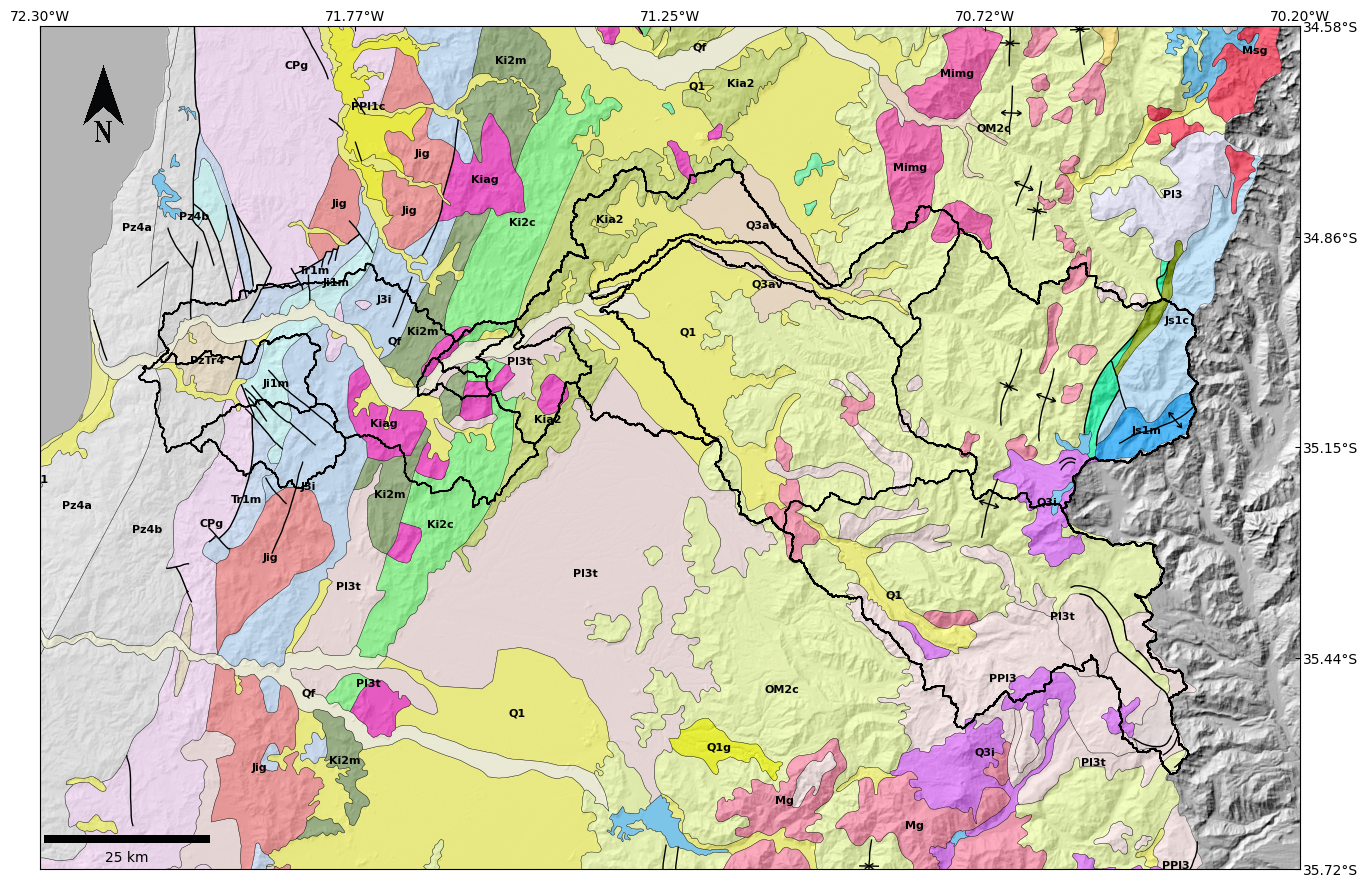

'print(f"\nGeologic units transparency set to: {geologic_transparency}")\nprint("Geologic units in your map and their colors:")\nfor unit in sorted(gdf[\'GEO\'].dropna().unique()):\n    color = geologic_colors.get(unit, \'#DDDDDD\')\n    print(f"{unit}: {color}")'

In [15]:
# Load the geological data
gdf = gpd.read_file('/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/geo_centro_u19.shp')

# Load and overlay the watershed boundary
watershed_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/MataquitoRiver/30DEMwatersheddata/subwatersheds30m.shp'
watershed_gdf = gpd.read_file(watershed_path)
watershed_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

# Load and overlay lines (no augmentations)
lines_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/centros-line_centro_u19.shp'
try:
    lines_gdf = gpd.read_file(lines_path)
    lines_gdf.plot(ax=ax, color='black', linewidth=1)
    print("Lines loaded successfully")
except Exception as e:
    print(f"Could not load lines: {e}")

# Load and overlay faults (no augmentations)
faults_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/fallas_centro_u19.shp'
try:
    faults_gdf = gpd.read_file(faults_path)
    faults_gdf.plot(ax=ax, color='black', linewidth=1)
    print("Faults loaded successfully")
except Exception as e:
    print(f"Could not load faults: {e}")

# Load and overlay fault symbols (no augmentations)
faultsymb_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/fallas-simb_centro_u19.shp'
try:
    faultsymb_gdf = gpd.read_file(faultsymb_path)
    faultsymb_gdf.plot(ax=ax, color='black', linewidth=1)
    print("Fault symbols loaded successfully")
except Exception as e:
    print(f"Could not load fault symbols: {e}")

#----------------------------------------------------------

""" Create the plot """
fig, ax = plt.subplots(figsize=(14, 10))

# Set bounds based on your coordinates
x_coords = [201707, 391646, 286002, 307351]
y_coords = [6117461, 6095743, 6042001, 6168995]
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Load and display hillshade FIRST (as background)
hillshade_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/hillshademauleregion.tif'
try:
    with rasterio.open(hillshade_path) as src:
        show(src, ax=ax, cmap='gray', alpha=1.0)
    print("Hillshade loaded successfully")
except Exception as e:
    print(f"Could not load hillshade: {e}")

# Plot each geologic unit with transparency OVER the hillshade
for unit in gdf['GEO'].unique():
    unit_data = gdf[gdf['GEO'] == unit]
    color = geologic_colors.get(unit, '#231f20')  # Default black if unit not found
    unit_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, 
                   alpha=0.7)
    
# Size threshold in square meters (5 km² = 5,000,000 m²)
min_area_threshold = 50000000  # 5 km² - adjust as needed
# ADD LABELS FOR GEOLOGIC UNITS (only within bounds and above size threshold)
for unit in gdf['GEO'].unique():
    if pd.notna(unit):  # Skip NaN values
        unit_data = gdf[gdf['GEO'] == unit]
        # For each polygon in this unit
        for idx, row in unit_data.iterrows():
            # Check if polygon is large enough and centroid is within bounds
            if row.geometry.area >= min_area_threshold:
                centroid = row.geometry.centroid
                # Only add label if centroid is within plot bounds
                if (x_min <= centroid.x <= x_max and y_min <= centroid.y <= y_max):
                    ax.text(centroid.x, centroid.y, str(unit), 
                           fontsize=8, ha='center', va='center', weight='bold', clip_on=True)

# Overlay the watershed boundary
watershed_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

# Overlay lines (if loaded)
if 'lines_gdf' in locals() and lines_gdf is not None:
    lines_gdf.plot(ax=ax, color='black', linewidth=1)
# Overlay faults (if loaded)
if 'faults_gdf' in locals() and faults_gdf is not None:
    faults_gdf.plot(ax=ax, color='black', linewidth=1)
# Overlay fault symbols (if loaded)
if 'faultsymb_gdf' in locals() and faultsymb_gdf is not None:
    faultsymb_gdf.plot(ax=ax, color='black', linewidth=1)

# Load and display north arrow
hillshade_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/north_arrow.png'

# north arrow
try:
    from matplotlib.image import imread
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    
    north_arrow_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/north_arrow.png'
    north_arrow_img = imread(north_arrow_path)
    # Create an OffsetImage with the north arrow
    imagebox = OffsetImage(north_arrow_img, zoom=0.05)  # Adjust zoom as needed
    # Position it in the upper right corner
    ab = AnnotationBbox(imagebox, (0.05, 0.90), 
                        xycoords='axes fraction',
                        frameon=False)
    ax.add_artist(ab)
    print("North arrow PNG loaded successfully")
    
except Exception as e:
    print(f"Could not load north arrow PNG: {e}")

# Add scale bar without white background
try:
    from matplotlib_scalebar.scalebar import ScaleBar
    scalebar = ScaleBar(1, units="m", location="lower left", 
                       length_fraction=0.25, width_fraction=0.01,
                       box_alpha=0,  # Make background transparent
                       box_color='none',  # Remove box color
                       color='black')  # Set scale bar color
    ax.add_artist(scalebar)
except ImportError:
    # Fallback manual scale bar (no background box)
    scale_length = 15000  # 20 km
    scale_x = x_min + 0.05 * (x_max - x_min)
    scale_y = y_min + 0.05 * (y_max - y_min)
    
    ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], 'k-', linewidth=3)
    ax.text(scale_x + scale_length/2, scale_y + 2000, '20 km', ha='center', fontsize=10)

# Convert UTM coordinates to lat/long for axis labels
# Define UTM Zone 19S projection (typical for Chile)
utm_proj = Proj(proj='utm', zone=19, south=True, datum='WGS84')
wgs84_proj = Proj(proj='latlong', datum='WGS84')
# Convert corner coordinates to lat/long
x_corners = [x_min, x_max]
y_corners = [y_min, y_max]
lon_corners, lat_corners = transform(utm_proj, wgs84_proj, x_corners, y_corners)
# Create custom tick locations and labels
n_ticks = 5  # Number of ticks on each axis
# X-axis (longitude)
x_tick_positions = np.linspace(x_min, x_max, n_ticks)
x_tick_lons, _ = transform(utm_proj, wgs84_proj, x_tick_positions, [y_min] * n_ticks)
x_tick_labels = [f"{lon:.2f}°W" for lon in abs(x_tick_lons)]
# Y-axis (latitude) 
y_tick_positions = np.linspace(y_min, y_max, n_ticks)
_, y_tick_lats = transform(utm_proj, wgs84_proj, [x_min] * n_ticks, y_tick_positions)
y_tick_labels = [f"{lat:.2f}°S" for lat in abs(y_tick_lats)]
# Set custom ticks and labels
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels)
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels)
# Put labels on top and right side
ax.xaxis.tick_top()
ax.yaxis.tick_right()
# Put ticks inside the figure
ax.tick_params(direction='in', pad=4)
# Align tick labels inside the axes
ax.tick_params(axis='x', direction='in', pad=2, labeltop=True, labelbottom=False)
ax.tick_params(axis='y', direction='in', pad=2, labelright=True, labelleft=False)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Create output directory and save the plot
import os 
output_dir = "/Users/Glong1/Desktop/Andes/Mataquito_Manuscript"
os.makedirs(output_dir, exist_ok=True)
# Save the figure with high quality settings
output_path = os.path.join(output_dir, 'mataquito_geology_1-1000000.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Plot saved to: {output_path}")
# Also save as PDF for publication quality
pdf_path = os.path.join(output_dir, 'mataquito_geology_1-1000000.pdf')
plt.savefig(pdf_path, bbox_inches='tight', facecolor='white')
print(f"PDF version saved to: {pdf_path}")

# Display the plot
plt.show()

# Print the units found in your data with their assigned colors
"""print(f"\nGeologic units transparency set to: {geologic_transparency}")
print("Geologic units in your map and their colors:")
for unit in sorted(gdf['GEO'].dropna().unique()):
    color = geologic_colors.get(unit, '#DDDDDD')
    print(f"{unit}: {color}")"""

Lines loaded successfully
Faults loaded successfully
Fault symbols loaded successfully
Hillshade loaded successfully
North arrow PNG loaded successfully
Plot saved to: /Users/Glong1/Desktop/Andes/Mataquito_Manuscript/mataquito_geology_1-1000000.png
PDF version saved to: /Users/Glong1/Desktop/Andes/Mataquito_Manuscript/mataquito_geology_1-1000000.pdf


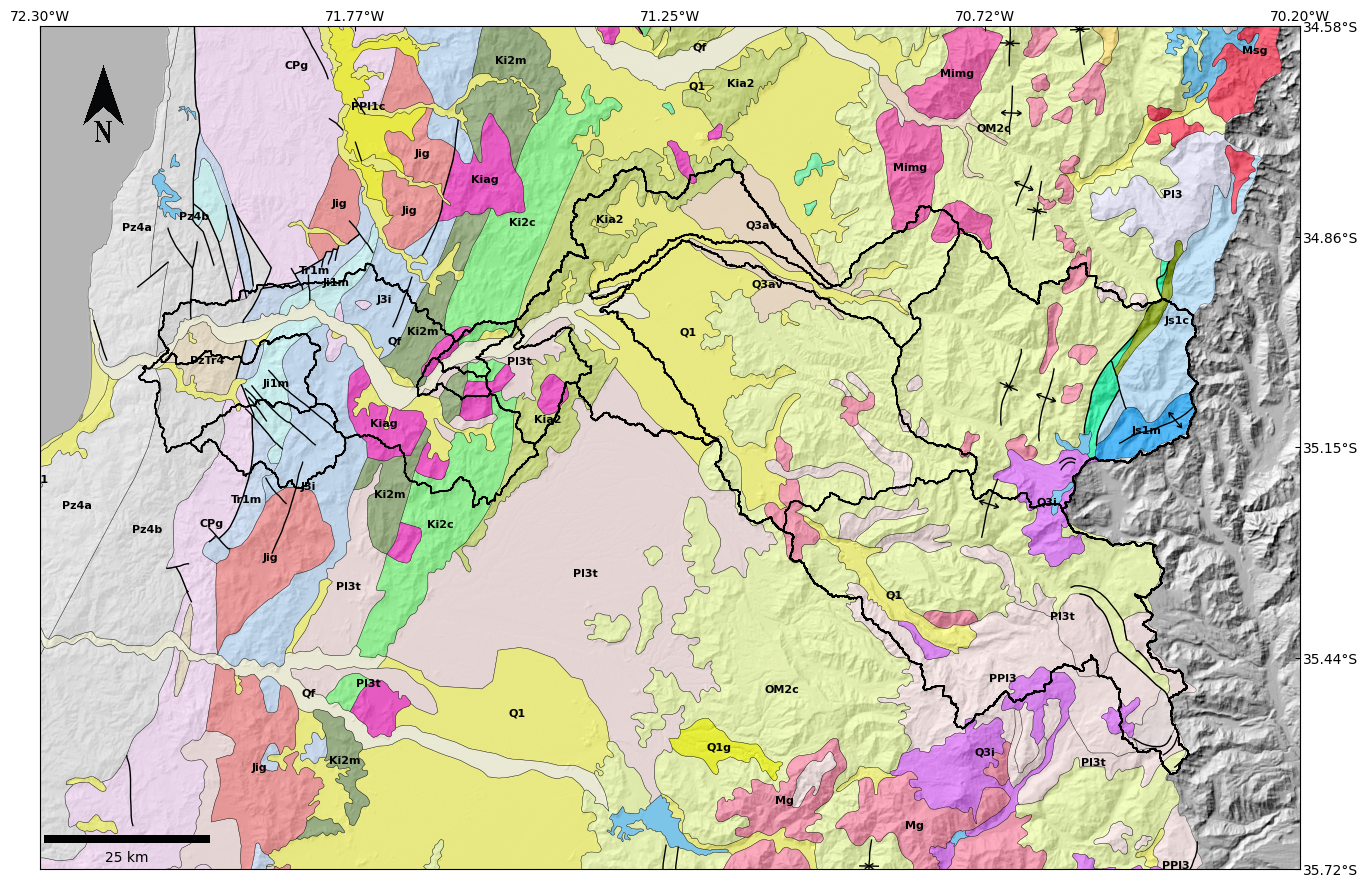

'print(f"\nGeologic units transparency set to: {geologic_transparency}")\nprint("Geologic units in your map and their colors:")\nfor unit in sorted(gdf[\'GEO\'].dropna().unique()):\n    color = geologic_colors.get(unit, \'#DDDDDD\')\n    print(f"{unit}: {color}")'

In [16]:
# SECTION 1: LOAD ALL DATA FIRST (no plotting yet)
# Load the geological data
gdf = gpd.read_file('/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/geo_centro_u19.shp')

# Load watershed boundary
watershed_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/MataquitoRiver/30DEMwatersheddata/subwatersheds30m.shp'
watershed_gdf = gpd.read_file(watershed_path)

# Load lines (no plotting yet)
lines_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/centros-line_centro_u19.shp'
lines_gdf = None
try:
    lines_gdf = gpd.read_file(lines_path)
    print("Lines loaded successfully")
except Exception as e:
    print(f"Could not load lines: {e}")

# Load faults (no plotting yet)
faults_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/fallas_centro_u19.shp'
faults_gdf = None
try:
    faults_gdf = gpd.read_file(faults_path)
    print("Faults loaded successfully")
except Exception as e:
    print(f"Could not load faults: {e}")

# Load fault symbols (no plotting yet)
faultsymb_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/fallas-simb_centro_u19.shp'
faultsymb_gdf = None
try:
    faultsymb_gdf = gpd.read_file(faultsymb_path)
    print("Fault symbols loaded successfully")
except Exception as e:
    print(f"Could not load fault symbols: {e}")

#----------------------------------------------------------

# SECTION 2: CREATE THE PLOT AND DO ALL PLOTTING
""" Create the plot """
fig, ax = plt.subplots(figsize=(14, 10))

# Set bounds based on your coordinates
x_coords = [201707, 391646, 286002, 307351]
y_coords = [6117461, 6095743, 6042001, 6168995]
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Load and display hillshade FIRST (as background)
hillshade_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/hillshademauleregion.tif'
try:
    with rasterio.open(hillshade_path) as src:
        show(src, ax=ax, cmap='gray', alpha=1.0)
    print("Hillshade loaded successfully")
except Exception as e:
    print(f"Could not load hillshade: {e}")

# Plot each geologic unit with transparency OVER the hillshade
for unit in gdf['GEO'].unique():
    unit_data = gdf[gdf['GEO'] == unit]
    color = geologic_colors.get(unit, '#231f20')  # Default black if unit not found
    unit_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, 
                   alpha=0.7)
    
# Size threshold in square meters (5 km² = 5,000,000 m²)
min_area_threshold = 50000000  # 5 km² - adjust as needed
# ADD LABELS FOR GEOLOGIC UNITS (only within bounds and above size threshold)
for unit in gdf['GEO'].unique():
    if pd.notna(unit):  # Skip NaN values
        unit_data = gdf[gdf['GEO'] == unit]
        # For each polygon in this unit
        for idx, row in unit_data.iterrows():
            # Check if polygon is large enough and centroid is within bounds
            if row.geometry.area >= min_area_threshold:
                centroid = row.geometry.centroid
                # Only add label if centroid is within plot bounds
                if (x_min <= centroid.x <= x_max and y_min <= centroid.y <= y_max):
                    ax.text(centroid.x, centroid.y, str(unit), 
                           fontsize=8, ha='center', va='center', weight='bold', clip_on=True)

# NOW plot all the overlays (after ax exists)
# Overlay the watershed boundary
watershed_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

# Overlay lines (if loaded)
if lines_gdf is not None:
    lines_gdf.plot(ax=ax, color='black', linewidth=1)

# Overlay faults (if loaded)  
if faults_gdf is not None:
    faults_gdf.plot(ax=ax, color='black', linewidth=1)

# Overlay fault symbols (if loaded)
if faultsymb_gdf is not None:
    faultsymb_gdf.plot(ax=ax, color='black', linewidth=1)

# Load and display north arrow
try:
    from matplotlib.image import imread
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    
    north_arrow_path = '/Users/Glong1/Desktop/Andes/Geologic_Map/north_arrow.png'
    north_arrow_img = imread(north_arrow_path)
    # Create an OffsetImage with the north arrow
    imagebox = OffsetImage(north_arrow_img, zoom=0.05)  # Adjust zoom as needed
    # Position it in the upper right corner
    ab = AnnotationBbox(imagebox, (0.05, 0.90), 
                        xycoords='axes fraction',
                        frameon=False)
    ax.add_artist(ab)
    print("North arrow PNG loaded successfully")
    
except Exception as e:
    print(f"Could not load north arrow PNG: {e}")

# Add scale bar without white background
try:
    from matplotlib_scalebar.scalebar import ScaleBar
    scalebar = ScaleBar(1, units="m", location="lower left", 
                       length_fraction=0.25, width_fraction=0.01,
                       box_alpha=0,  # Make background transparent
                       box_color='none',  # Remove box color
                       color='black')  # Set scale bar color
    ax.add_artist(scalebar)
except ImportError:
    # Fallback manual scale bar (no background box)
    scale_length = 15000  # 15 km 
    scale_x = x_min + 0.05 * (x_max - x_min)
    scale_y = y_min + 0.05 * (y_max - y_min)
    
    ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], 'k-', linewidth=3)
    ax.text(scale_x + scale_length/2, scale_y + 2000, '15 km', ha='center', fontsize=10)

# Convert UTM coordinates to lat/long for axis labels
# Define UTM Zone 19S projection (typical for Chile)
utm_proj = Proj(proj='utm', zone=19, south=True, datum='WGS84')
wgs84_proj = Proj(proj='latlong', datum='WGS84')
# Convert corner coordinates to lat/long
x_corners = [x_min, x_max]
y_corners = [y_min, y_max]
lon_corners, lat_corners = transform(utm_proj, wgs84_proj, x_corners, y_corners)
# Create custom tick locations and labels
n_ticks = 5  # Number of ticks on each axis
# X-axis (longitude)
x_tick_positions = np.linspace(x_min, x_max, n_ticks)
x_tick_lons, _ = transform(utm_proj, wgs84_proj, x_tick_positions, [y_min] * n_ticks)
x_tick_labels = [f"{lon:.2f}°W" for lon in abs(x_tick_lons)]
# Y-axis (latitude) 
y_tick_positions = np.linspace(y_min, y_max, n_ticks)
_, y_tick_lats = transform(utm_proj, wgs84_proj, [x_min] * n_ticks, y_tick_positions)
y_tick_labels = [f"{lat:.2f}°S" for lat in abs(y_tick_lats)]
# Set custom ticks and labels
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels)
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels)
# Put labels on top and right side
ax.xaxis.tick_top()
ax.yaxis.tick_right()
# Put ticks inside the figure
ax.tick_params(direction='in', pad=4)
# Align tick labels inside the axes
ax.tick_params(axis='x', direction='in', pad=2, labeltop=True, labelbottom=False)
ax.tick_params(axis='y', direction='in', pad=2, labelright=True, labelleft=False)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Create output directory and save the plot
import os 
output_dir = "/Users/Glong1/Desktop/Andes/Mataquito_Manuscript"
os.makedirs(output_dir, exist_ok=True)
# Save the figure with high quality settings
output_path = os.path.join(output_dir, 'mataquito_geology_1-1000000.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Plot saved to: {output_path}")
# Also save as PDF for publication quality
pdf_path = os.path.join(output_dir, 'mataquito_geology_1-1000000.pdf')
plt.savefig(pdf_path, bbox_inches='tight', facecolor='white')
print(f"PDF version saved to: {pdf_path}")

# Display the plot
plt.show()

# Print the units found in your data with their assigned colors
"""print(f"\nGeologic units transparency set to: {geologic_transparency}")
print("Geologic units in your map and their colors:")
for unit in sorted(gdf['GEO'].dropna().unique()):
    color = geologic_colors.get(unit, '#DDDDDD')
    print(f"{unit}: {color}")"""

Map visualization saved to: /Users/Glong1/Desktop/Andes/Geologic_Map/complete_geologic_map.png


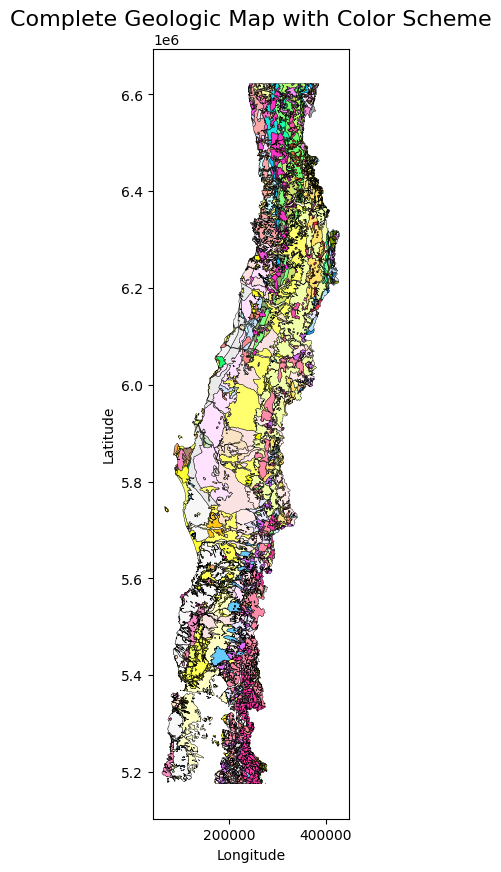

Colored shapefile saved to: /Users/Glong1/Desktop/Andes/Geologic_Map/geo_centro_colored.shp

Total features: 4525
Unique geologic units: 93

Geologic units found in your data:
  CP1: #ffdfff
  CPg: #ffe2ff
  DC1: #b76e00
  DC4: #f0e2e2
  E1c: #faa86e
  E1m: #fae200
  Eg: #ff51a8
  G: #66CCFF
  Hielo: #DDDDDD
  J2m: #c5ffff
  J3a: #b7cde2
  J3i: #c5e2ff
  JK1m: #85a800
  JK3: #17e2e2
  Ji1m: #ceffff
  Jig: #fa8b8b
  Js1c: #b7e2ff
  Js1m: #17a8ff
  Js2c: #0ecdff
  Jsg: #faa8a8
  KT2: #a8ff8b
  KTg: #ff6e34
  Ki1m: #6ec517
  Ki2c: #81ff81
  Ki2m: #8ba86e
  Kia1c: #17ffa8
  Kia2: #cee26e
  Kia3: #6effa8
  Kiag: #fa34c5
  Kibg: #ff6ec5
  Kig: #ff34a8
  Ks1m: #17ff6e
  Ks2c: #6eff6e
  Ks3a: #b7ff51
  Ks3i: #b7ff6e
  Ksg: #ff34e2
  Ksh: #ff8be2
  Lag: #66CCFF
  M1c: #fae28b
  M1m: #fa8bc5
  M3b: #f5c5a8
  M3i: #ffe26e
  MP1c: #fac58b
  MP1m: #ffe2e2
  MP2: #f5a8a8
  MP3: #ffc58b
  Mg: #ff8ba8
  Mh: #d8a800
  Mimg: #fa51a8
  Ms3i: #fa8b6e
  Msg: #ff3451
  Msh: #faa800
  OM1c: #ffa86e
  OM1m: #

/Users/Glong1/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 4368528000 of field AREA of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/Users/Glong1/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 4368528000 of field AREATNT of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/Users/Glong1/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 5214349000 of field AREA of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/Users/Glong1/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 5214349000 of field AREATNT of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/Users/Glong1/anaconda3/lib/python3.11/site-packages/pyogr

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# Load the shapefile
gdf = gpd.read_file('/Users/Glong1/Desktop/Andes/Geologic_Map/1Mio/Chile/geo_centro_u19.shp')

# Add a color column to the GeoDataFrame based on the GEO unit
# This will help QGIS understand the colors
gdf['color'] = gdf['GEO'].map(geologic_colors)
# For any units without a defined color, use a default gray
gdf['color'] = gdf['color'].fillna('#DDDDDD')

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Plot each geologic unit with its color
for unit in gdf['GEO'].unique():
    if unit is not None:  # Skip any null values
        unit_data = gdf[gdf['GEO'] == unit]
        color = geologic_colors.get(unit, '#DDDDDD')  # Default gray if unit not in dictionary
        unit_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, alpha=1.0)

plt.title('Complete Geologic Map with Color Scheme', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot as an image
output_dir = "/Users/Glong1/Desktop/Andes/Geologic_Map"
os.makedirs(output_dir, exist_ok=True)

plot_path = os.path.join(output_dir, 'complete_geologic_map.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Map visualization saved to: {plot_path}")

plt.show()

# Save the shapefile with color information for QGIS
output_shapefile = os.path.join(output_dir, 'geo_centro_colored.shp')
gdf.to_file(output_shapefile)
print(f"Colored shapefile saved to: {output_shapefile}")

# Print summary
print(f"\nTotal features: {len(gdf)}")
print(f"Unique geologic units: {gdf['GEO'].nunique()}")
print("\nGeologic units found in your data:")
for unit in sorted(gdf['GEO'].dropna().unique()):
    color = geologic_colors.get(unit, '#DDDDDD')
    print(f"  {unit}: {color}")